In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
import chess
from sarfa import core, BoardVisualization, SarfaBaseline, Engine, RemovalPerturber, SarfaComputeResult, get_all_pos
from IPython.display import Image, display
from collections import defaultdict

# Configure Test

In [3]:
{"fen":"3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1","responseMoves":["Rxf7"],"saliencyGroundTruth":["f1","h2","c3","e1","b3","h7","g3","g7"],"solution":["Rxf7","Qxc7"]}

{'fen': '3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1',
 'responseMoves': ['Rxf7'],
 'saliencyGroundTruth': ['f1', 'h2', 'c3', 'e1', 'b3', 'h7', 'g3', 'g7'],
 'solution': ['Rxf7', 'Qxc7']}

In [3]:
FEN = "r2qrbk1/1bp2ppp/p2p1n2/2p2NB1/4P3/2N2Q2/PPP2PPP/R3R1K1 w - - 0 1"
action = None
DISCOUNT_FACTOR = 0.9
DEPTH = 3
RUNTIME=2.0

In [7]:
name = f"sarfa_sequential_{int(RUNTIME * 10)}_{int(DISCOUNT_FACTOR * 100)}_{DEPTH}"

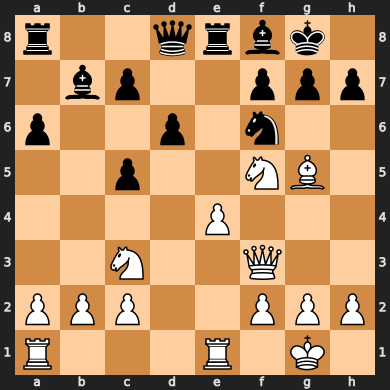

In [6]:
board = chess.Board(FEN)
board_visualization = BoardVisualization(board)
board_visualization.only_board()

# Algorithm Test

In [32]:
engine = Engine("./stockfish_15_x64_avx2")

def sequential_saliency_algorithm(fen, discount_factor, depth, runtime=2.0):
    saliency_results_per_step = []
    moves_taken = []
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    
    current_to_original_pos_mapping = {pos: pos for pos in get_all_pos()}

    for curr_step in range(0, depth):
        print(f"curr step: {curr_step}")
        saliency_calculator = SarfaBaseline(engine, board, runtime=runtime)
        
        optimal_move, optimal_move_q = None, 0
        saliency_results_timestep = defaultdict(int)

        for perturbed_board, perturbed_position_str in perturber.process():
            sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, None)

            # update the optimal action for this depth
            # don't take an action that is coming from perturbation
            # leading to check
            if sarfa_compute_result.optimal_move_q_val != float("inf") and \
                (not optimal_move or sarfa_compute_result.optimal_move_q_val > optimal_move_q):
                optimal_move = sarfa_compute_result.optimal_move
                optimal_move_q = sarfa_compute_result.optimal_move_q_val
            
            perturbed_position_original_str = current_to_original_pos_mapping[perturbed_position_str]
            saliency_results[perturbed_position_original_str] += (sarfa_compute_result.saliency * (discount_factor ** curr_step))
            saliency_results_timestep[perturbed_position_original_str] += sarfa_compute_result.saliency
        if not optimal_move:
            print("no vaid move found")
            break
        saliency_results_per_step.append((saliency_results_timestep.copy(), board.copy()))

        # take optimal action on the current board
        # use this new board is the action for next iteration
        optimal_move_obj = chess.Move.from_uci(optimal_move)
        moves_taken.append(optimal_move_obj)
        board.push(optimal_move_obj)

        # update mapping
        if (not board.is_game_over()):
            start_move_pos = optimal_move[0:2]
            end_move_pos = optimal_move[2:4]
            current_to_original_pos_mapping[end_move_pos] = current_to_original_pos_mapping[start_move_pos]
        else:
            print("game finished early")
            break
    
    return saliency_results, saliency_results_per_step, moves_taken

## 2 Seconds

In [27]:
saliency_results_per_step = []
moves_taken = []

saliency_results, saliency_results_per_step, moves_taken = sequential_saliency_algorithm(FEN, DISCOUNT_FACTOR, DEPTH, runtime=2.0)

curr step: 0
a2
b2
b3
b6
b7
c3
c7
d8
e1
f1
f7
f8
g2
g3
g7
h2
h6
h7
curr step: 1
a2
b2
b3
b6
b7
c3
c7
d8
e1
f7
f8
g2
g3
g7
h2
h6
h7
curr step: 2
a2
b2
b3
b6
b7
c3
c7
d8
e1
f7
f8
g2
g3
g6
g7
h2
h7


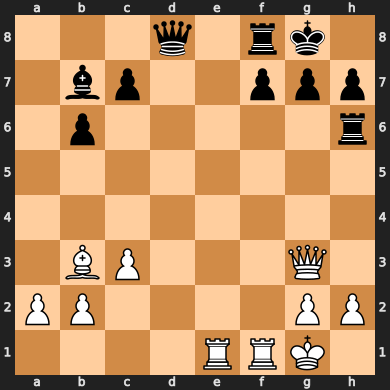

In [22]:
board

Important: 
["f1","h2","c3","e1","b3","h7","g3","g7"]

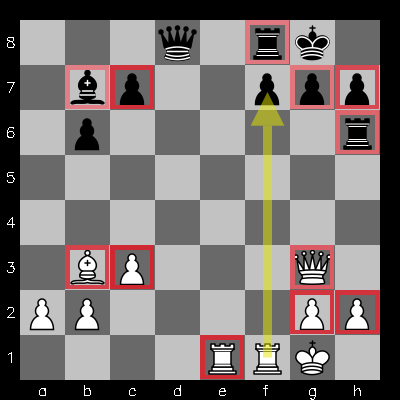

In [23]:
board_visualization = BoardVisualization(chess.Board(FEN))
path = board_visualization.show_heatmap(saliency_results, moves_taken[0])
display(Image(path))

In [24]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage

def show_progression(saliency_timestep, moves_taken: dict[int, chess.Move]):


    # Create a grid of subplots (1 row, 3 columns)
    fig, axes = plt.subplots(1, DEPTH, figsize=(15, 5))  # Adjust the size as needed

    # Loop through indices 1 through 3
    for step in range(DEPTH):  # 1 through 3 inclusive
        board_visualization = BoardVisualization(saliency_timestep[step][1])
        path = board_visualization.show_heatmap(saliency_timestep[step][0], moves_taken[step])
        img = PILImage.open(path)
        
        # Display the image in the corresponding subplot
        axes[step].imshow(img)
        axes[step].axis('off')  # Turn off axis
        axes[step].set_title(f"Timestep {step}", fontsize=12)

    # Adjust layout and show the grid
    plt.tight_layout()
    plt.show()


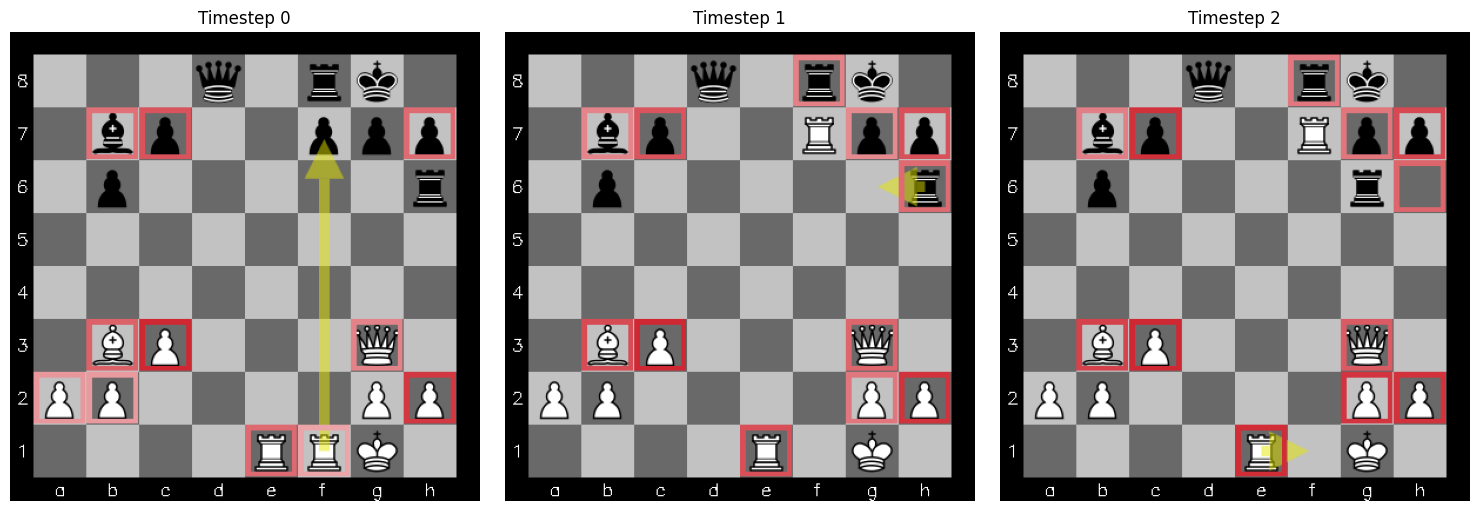

In [25]:
show_progression(saliency_results_per_step, moves_taken)

## 4 Seconds

In [13]:
saliency_results_per_step = []
moves_taken = []

saliency_results = sequential_saliency_algorithm(FEN, DISCOUNT_FACTOR, DEPTH, runtime=4.0)

curr step: 0
curr step: 1
curr step: 2


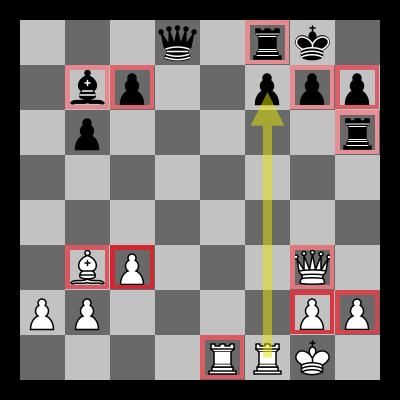

In [18]:
board_visualization = BoardVisualization(chess.Board(FEN))
path = board_visualization.show_heatmap(saliency_results, moves_taken[0])
display(Image(path))

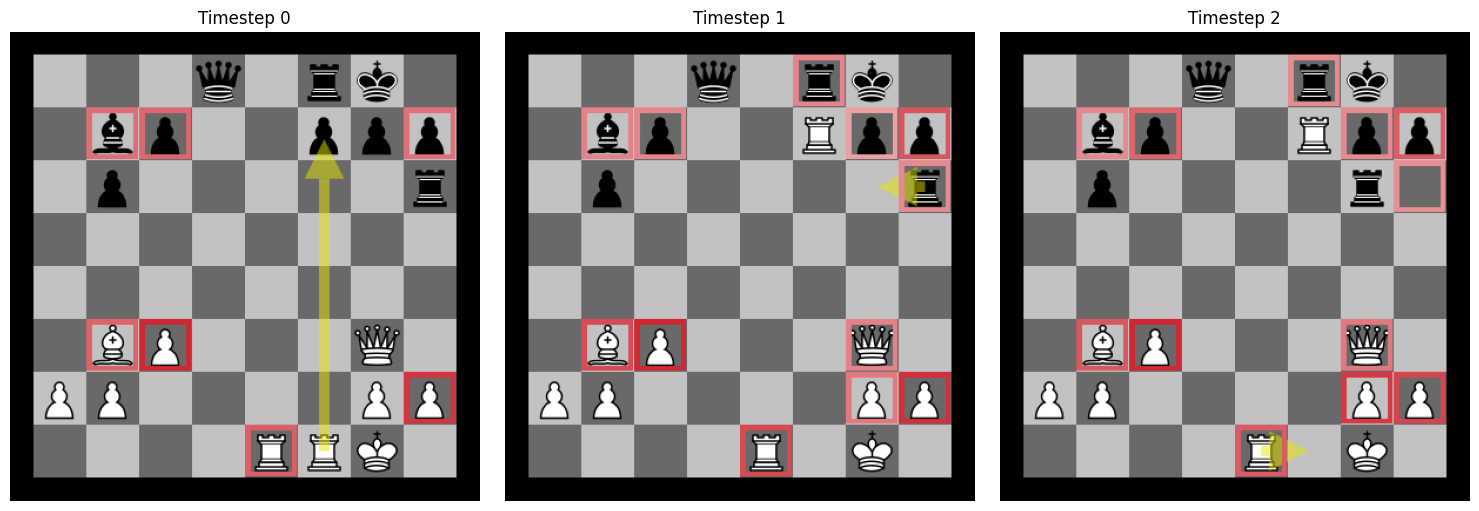

In [19]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Create a grid of subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, DEPTH, figsize=(15, 5))  # Adjust the size as needed

# Loop through indices 1 through 3
for step in range(DEPTH):  # 1 through 3 inclusive
    board_visualization = BoardVisualization(saliency_results_per_step[step][1])
    path = board_visualization.show_heatmap(saliency_results_per_step[step][0], moves_taken[step])
    img = PILImage.open(path)
    
    # Display the image in the corresponding subplot
    axes[step].imshow(img)
    axes[step].axis('off')  # Turn off axis
    axes[step].set_title(f"Timestep {step}", fontsize=12)

# Adjust layout and show the grid
plt.tight_layout()
plt.show()


# Benchmark

In [4]:
from chess_dataset import SafraBenchmark
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [16]:
sequential_benchmark_function = lambda x, _: sequential_saliency_algorithm(x, DISCOUNT_FACTOR, DEPTH, RUNTIME)[0]


In [5]:
benchmark = SafraBenchmark(sequential_benchmark_function, name=name, sanity_check=False)

NameError: name 'name' is not defined

# Analysis

In [8]:
sarfa_benchmark = SafraBenchmark.load_results(sequential_benchmark_function, name)

In [9]:
sarfa_benchmark.accuracy()

{'accuracy - harmonic_mean': 0.7143901852504448}

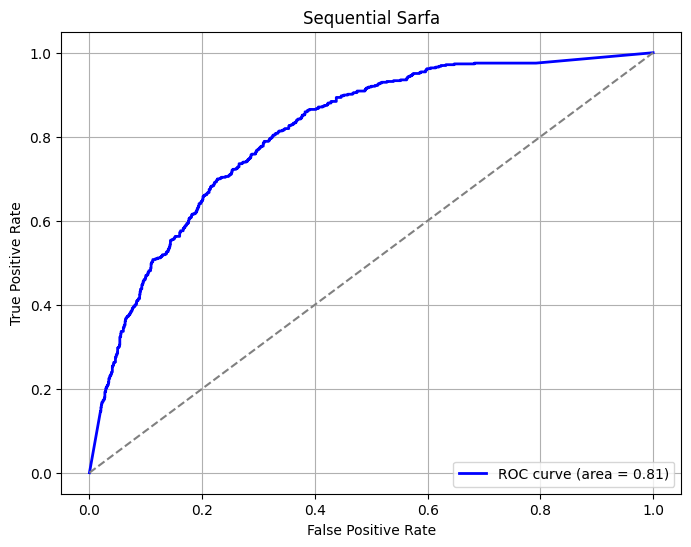

In [51]:
fig = sarfa_benchmark.plot_roc(name="Sequential Sarfa")
display(fig)

## Show Divergent Move Choices

```json
{
    "fen":"3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1",
    "responseMoves":["Rxf7"],
    "saliencyGroundTruth":["f1","h2","c3","e1","b3","h7","g3","g7"],
    "solution":["Rxf7","Qxc7"]
}

```

In [68]:
FEN = "3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1"
board = chess.Board(FEN)
board_visualizer = BoardVisualization(board.copy())

predicted_saliency, predicted_saliency_timestamps, predicted_moves = sequential_saliency_algorithm(FEN, DISCOUNT_FACTOR, DEPTH)


curr step: 0
curr step: 1
curr step: 2


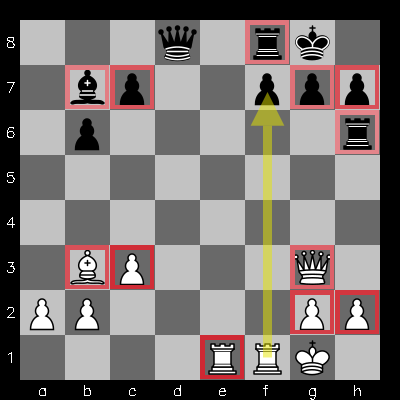

In [30]:
board_visualizer = BoardVisualization(board.copy())

path = board_visualizer.show_heatmap(predicted_saliency, predicted_moves[0])
display(Image(path))

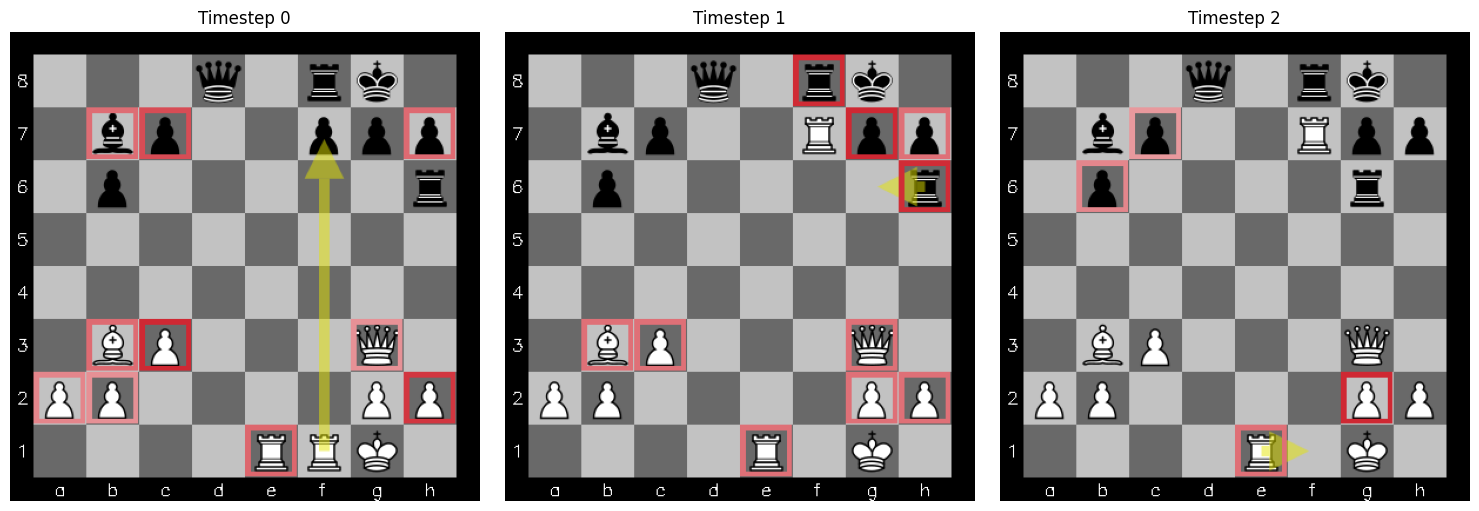

In [31]:
show_progression(predicted_saliency_timestamps, predicted_moves)

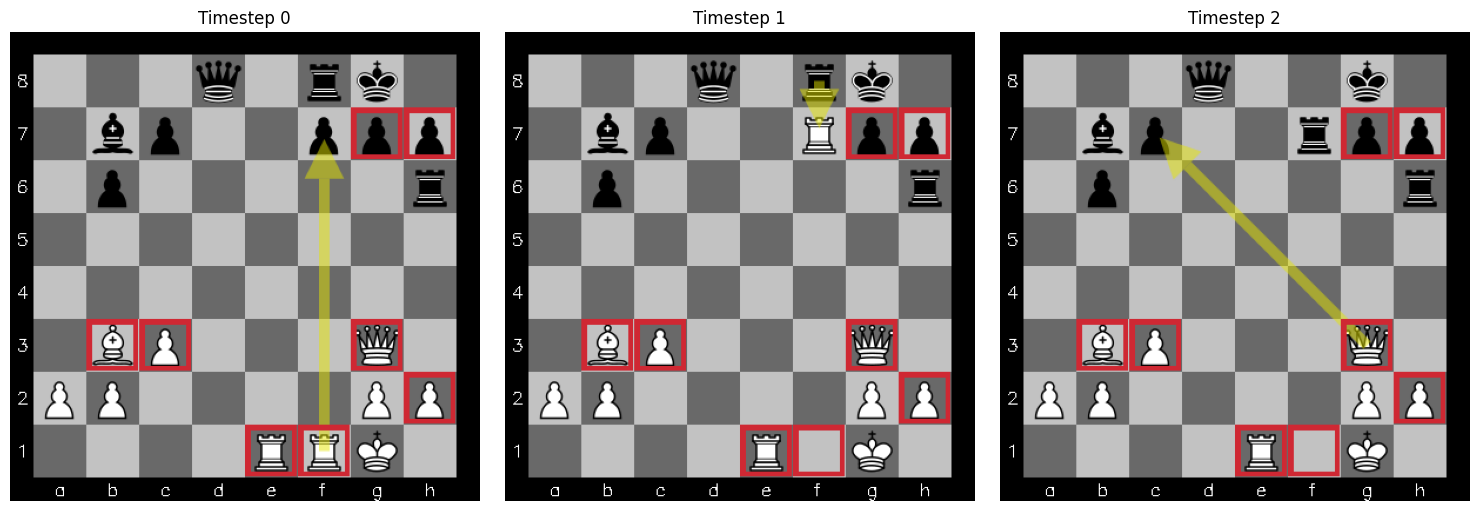

In [33]:
ground_truth_moves = ["Rxf7","Rxf7", "Qxc7"]
board = chess.Board(FEN)
saliency = {k: 1 for k in ["f1","h2","c3","e1","b3","h7","g3","g7"]}


ground_truth_boards = []
uci_moves = []
for move in ground_truth_moves:
    ground_truth_boards.append((
        saliency,
        board.copy())
    )
    uci = board.push_san(move)
    uci_moves.append(uci)


show_progression(ground_truth_boards, uci_moves)

In [73]:
# Show the final board for ground truth and calculated side by side
from PIL import Image as PILImage

import matplotlib.pyplot as plt
from PIL import Image as PILImage

def show_saliency_comparison(fen, saliencies, names, best_move: chess.Move):
    """
    Displays a comparison of saliency heatmaps in a 1 x n row.
    Takes in a list of saliencies and corresponding names.
    
    Parameters:
    - fen (str): FEN of the current chessboard.
    - saliencies (list): List of saliency data for each heatmap.
    - names (list): List of titles to be used for each subplot.
    - best_move (chess.Move): The best move to be visualized on the board.
    """
    
    # Initialize the board visualizer
    board_visualizer = BoardVisualization(chess.Board(fen))

    # Create a figure with 1 row and n columns (length of the saliencies list)
    fig, axes = plt.subplots(1, len(saliencies), figsize=(12, 6))

    # Ensure axes is iterable even if there's only one subplot
    if len(saliencies) == 1:
        axes = [axes]

    # Loop over each saliency and its corresponding name
    for i, (saliency, name) in enumerate(zip(saliencies, names)):
        board_visualizer.DRAWING_FILE = f"svg_custom/board_{name}"
        path = board_visualizer.show_heatmap(saliency, best_move)
        
        # Load the saliency image
        img = PILImage.open(path)
        
        # Display the image in the corresponding subplot
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide the axes
        axes[i].set_title(name)

    # Adjust the layout to avoid overlap
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05)  # Reduce the width spacing


    # Show the plot
    plt.show()



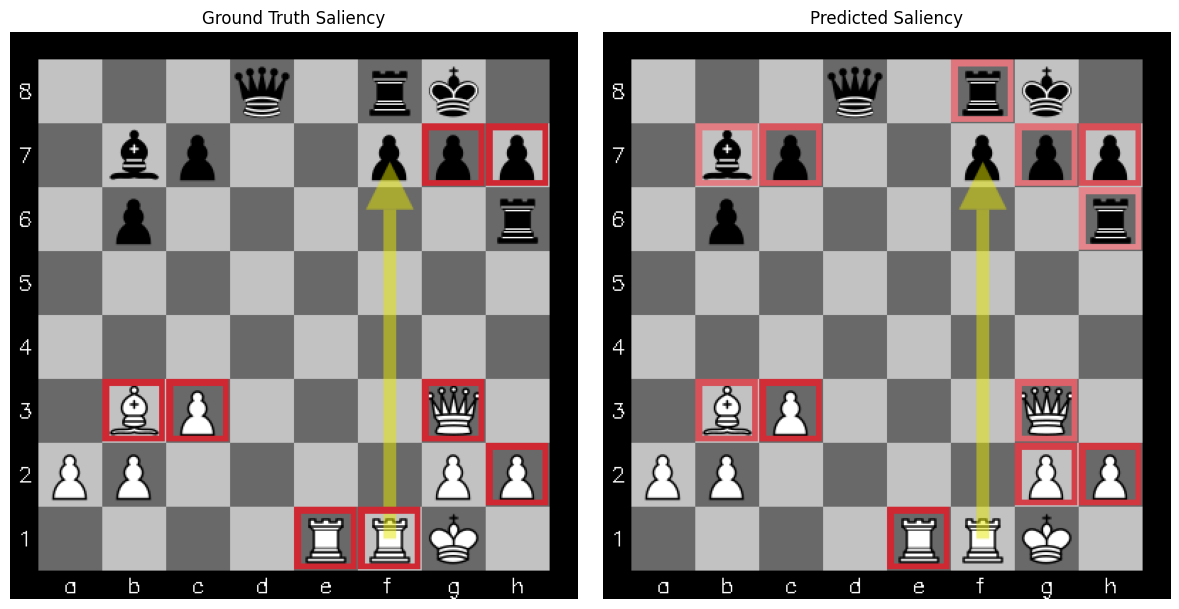

In [49]:
board = chess.Board(FEN)
possible_moves = list(board.legal_moves)
_, optimal_move = engine.q_values(board, possible_moves, len(possible_moves), runtime=2.0)

show_saliency_comparison(FEN, ground_truth_boards[0][0], predicted_saliency, chess.Move.from_uci(optimal_move))

## Compare When Taking the Same Actions

In [54]:
FEN = "3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1"
ground_truth_moves = ["Rxf7","Rxf7", "Qxc7"]
ground_truth_saliency = {k: 1 for k in ["f1","h2","c3","e1","b3","h7","g3","g7"]}

In [52]:
engine = Engine("./stockfish_15_x64_avx2")

def sequential_saliency_algorithm_forced_moves(fen, discount_factor, depth, forced_moves, runtime=2.0):
    saliency_results_per_step = []
    moves_taken = []
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    
    current_to_original_pos_mapping = {pos: pos for pos in get_all_pos()}

    for curr_step in range(0, depth):
        print(f"curr step: {curr_step}")
        saliency_calculator = SarfaBaseline(engine, board, runtime=runtime)
        
        optimal_move, optimal_move_q = None, 0
        saliency_results_timestep = defaultdict(int)

        for perturbed_board, perturbed_position_str in perturber.process():
            sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, None)

            # update the optimal action for this depth
            # don't take an action that is coming from perturbation
            # leading to check
            if sarfa_compute_result.optimal_move_q_val != float("inf") and \
                (not optimal_move or sarfa_compute_result.optimal_move_q_val > optimal_move_q):
                optimal_move = sarfa_compute_result.optimal_move
            
            perturbed_position_original_str = current_to_original_pos_mapping[perturbed_position_str]
            saliency_results[perturbed_position_original_str] += (sarfa_compute_result.saliency * (discount_factor ** curr_step))
            saliency_results_timestep[perturbed_position_original_str] += sarfa_compute_result.saliency
        if not optimal_move:
            print("no vaid move found")
            break
        saliency_results_per_step.append((saliency_results_timestep.copy(), board.copy()))

        # take optimal action on the current board
        # use this new board is the action for next iteration
        move_uci = board.push_san(forced_moves[curr_step])
        moves_taken.append(move_uci)

        # update mapping
        if (not board.is_game_over()):
            start_move_pos = optimal_move[0:2]
            end_move_pos = optimal_move[2:4]
            current_to_original_pos_mapping[end_move_pos] = current_to_original_pos_mapping[start_move_pos]
        else:
            print("game finished early")
            break
    
    return saliency_results, saliency_results_per_step, moves_taken

In [67]:
predicted_saliency_forced_moves, predicted_saliency_timestamps, predicted_moves = sequential_saliency_algorithm_forced_moves(FEN, DISCOUNT_FACTOR, DEPTH, ground_truth_moves)


curr step: 0
curr step: 1
curr step: 2


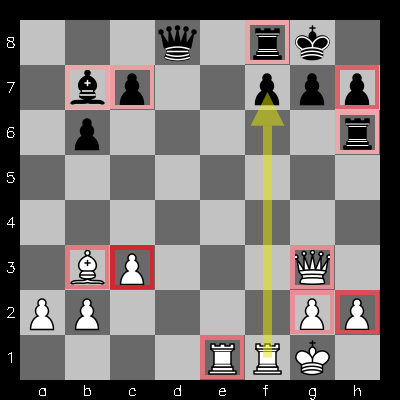

In [59]:
board_visualizer = BoardVisualization(board.copy())

path = board_visualizer.show_heatmap(predicted_saliency, predicted_moves[0])
display(Image(path))

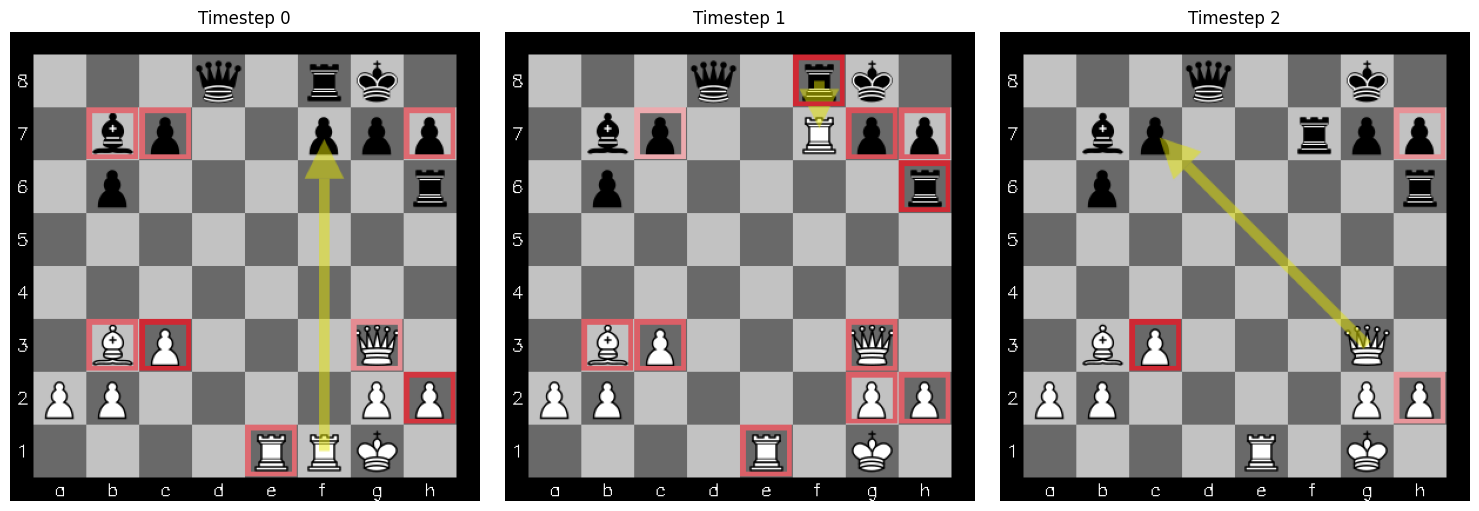

In [60]:
show_progression(predicted_saliency_timestamps, predicted_moves)

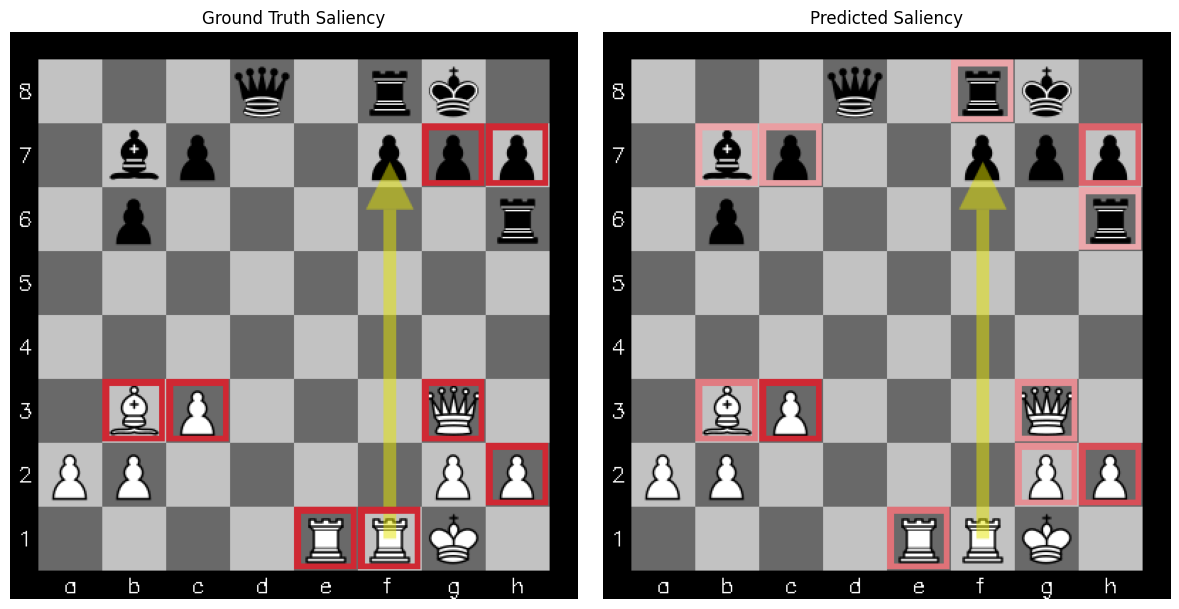

In [63]:
board = chess.Board(FEN)
possible_moves = list(board.legal_moves)
_, optimal_move = engine.q_values(board, possible_moves, len(possible_moves), runtime=2.0)

show_saliency_comparison(FEN, ground_truth_saliency, predicted_saliency, chess.Move.from_uci(optimal_move))

## Final Board Comparisons

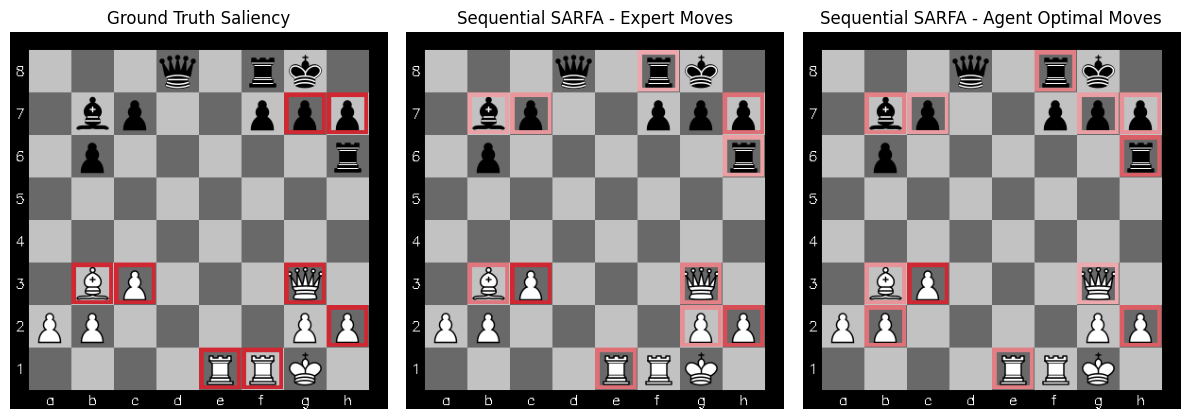

In [74]:
board = chess.Board(FEN)
possible_moves = list(board.legal_moves)
_, optimal_move = engine.q_values(board, possible_moves, len(possible_moves), runtime=2.0)

show_saliency_comparison(FEN, 
    [ground_truth_saliency, predicted_saliency_forced_moves, predicted_saliency], 
    ["Ground Truth Saliency", "Sequential SARFA - Expert Moves", "Sequential SARFA - Agent Optimal Moves"],
    None)